MENGGUNAKAN DATA RICE IMAGE DARI [Kaggle](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/data)

# CLONING DATASET DARI GITHUB YANG SUDAH DIUNGGAH

In [6]:
!git clone https://github.com/trisya07/classification_of_rice_types.git

Cloning into 'classification_of_rice_types'...
remote: Enumerating objects: 74713, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 74713 (delta 0), reused 3 (delta 0), pack-reused 74710 (from 1)
Receiving objects: 100% (74713/74713), 205.73 MiB | 26.43 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (75000/75000), done.


# INSTALL LIBRARY YANG DIPERLUKAN

In [1]:
!pip install split-folders

# IMPORT LIBRARY

In [1]:
import splitfolders
import os
import shutil
import random
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflowjs as tfjs
from tensorflow.keras.models import load_model
import cv2
import matplotlib.image as mpimg

# SPLIT DATASET MENJADI TRAIN 70%, VAL 20%, TEST 10%

In [9]:
# split menjadi train 70%, val 20%, test 10$
splitfolders.ratio(
    "/content/classification_of_rice_types/dataset", # direktori asal
    output="/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_split",                    # direktori tujuan
    seed=1337,
    ratio=(.7, .2, .1),
    move=False
)

Copying files: 75000 files [15:56, 78.41 files/s]


In [12]:
# cek hasil split
for folder in ['train', 'val', 'test']:
    print(f"\n{folder.upper()}:")
    for class_name in os.listdir(f"/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_split/{folder}"):
        n = len(os.listdir(f"/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_split/{folder}/{class_name}"))
        print(f"{class_name}: {n} gambar")


TRAIN:
Basmati: 10500 gambar
karacadag: 10500 gambar
Jasmine: 10500 gambar
Arborio: 10500 gambar
Ipsala: 10500 gambar

VAL:
Basmati: 3000 gambar
karacadag: 3000 gambar
Jasmine: 3000 gambar
Arborio: 3000 gambar
Ipsala: 3000 gambar

TEST:
Basmati: 1500 gambar
karacadag: 1500 gambar
Jasmine: 1500 gambar
Arborio: 1500 gambar
Ipsala: 1500 gambar


In [14]:
# Membuat zip hasil split data
!zip -r dataset_split.zip "/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_split"

Output streaming akan dipotong hingga 5000 baris terakhir.
  adding: content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_split/test/karacadag/Karacadag (5560).jpg (deflated 23%)
  adding: content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_split/test/karacadag/Karacadag (650).jpg (deflated 23%)
  adding: content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_split/test/karacadag/Karacadag (1060).jpg (deflated 23%)
  adding: content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_split/test/karacadag/Karacadag (5995).jpg (deflated 23%)
  adding: content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_split/test/karacadag/Karacadag (10).jpg (deflated 21%)
  adding: content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_split/test/karacadag/Karacadag (2381).jpg (deflated 22%)
  adding: content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_split/test/karacadag/Karacadag (9619).jpg (deflat

In [15]:
# mendownload zip data hasil split
from google.colab import files
files.download("/content/dataset_split.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# MENDEFINISIKAN VARIABEL YANG AKAN DIGUNAKAN

# LOAD DATASET

## MENGURANGI DATASET AGAR BISA DIJALANKAN DI COLAB (GA KUAT)

In [3]:
# Path dataset asal
source_base = "/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_split"

# Path dataset baru
target_base = "/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_kecil"

# Jumlah gambar per kelas
split_config = {
    "train": 2000,
    "val": 400,
    "test": 200
}

In [4]:
# salin gambar acak dari tiap kelas ke folder baru
def copy_images_per_class(src_dir, dst_dir, num_per_class):
    os.makedirs(dst_dir, exist_ok=True)
    class_names = os.listdir(src_dir)

    for class_name in class_names:
        src_class_dir = os.path.join(src_dir, class_name)
        dst_class_dir = os.path.join(dst_dir, class_name)
        os.makedirs(dst_class_dir, exist_ok=True)

        images = os.listdir(src_class_dir)
        random.shuffle(images)
        selected_images = images[:num_per_class]

        for img in tqdm(selected_images, desc=f"Copying {class_name}"):
            shutil.copy(os.path.join(src_class_dir, img), os.path.join(dst_class_dir, img))

In [5]:
# split data ke dataset_kecil
for split in ["train", "val", "test"]:
    src_dir = os.path.join(source_base, split)
    dst_dir = os.path.join(target_base, split)
    num = split_config[split]
    copy_images_per_class(src_dir, dst_dir, num)

Copying Ipsala: 100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


In [2]:
# Defining variables yang akan digunakan pemodelan
BATCH_SIZE = 16
IMAGE_SIZE = 128

In [3]:
# Retrieve images from train, valid, and test directories
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_kecil/train",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_kecil/val",
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_kecil/test",
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = train_dataset.class_names

Found 10000 files belonging to 5 classes.
Found 2000 files belonging to 5 classes.
Found 1000 files belonging to 5 classes.


In [4]:
# Cache, shuffle, prefetch
train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# PRE-PROCESSING

In [5]:
# normalisasi citra menjadi rentang dari [0,255] menjadi [0,1]
rescaling = tf.keras.Sequential([
    layers.Rescaling(1.0/255)
])

In [6]:
# augmentasi data dengan flip secara horizontal dan vertikal serta rotasi secara random sebesar 10%
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1)
])

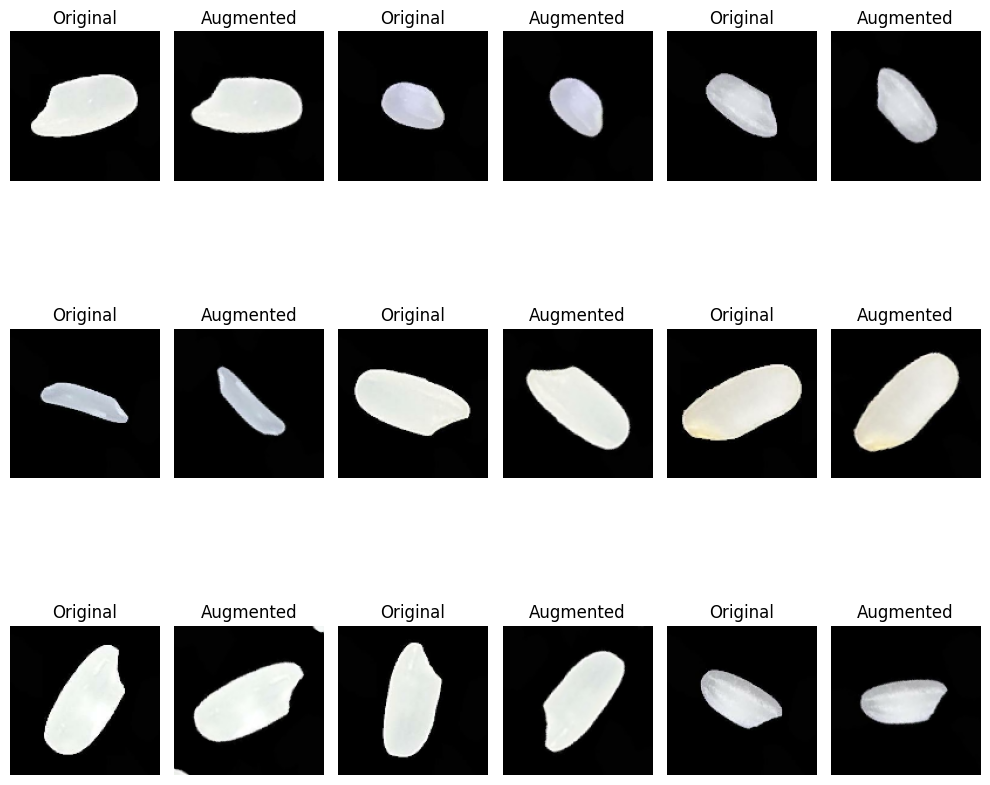

In [11]:
# menampilkan contoh gambar hasil augmentasi
# Ambil satu batch dari train_dataset
for images, labels in train_dataset.take(1):
    # Terapkan augmentasi ke batch gambar
    augmented_images = data_augmentation(images)

    # Tampilkan beberapa gambar asli dan hasil augmentasi
    plt.figure(figsize=(10, 10))
    for i in range(9):
        # Gambar asli
        plt.subplot(3, 6, 2*i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")

        # Gambar hasil augmentasi
        plt.subplot(3, 6, 2*i + 2)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title("Augmented")
        plt.axis("off")
    break
plt.tight_layout()
plt.show()

# MODELING

In [7]:
# memanggil function pre-processing dan membuat model
model = models.Sequential([
    data_augmentation,
    rescaling,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
# menambahkan callback early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [9]:
# training dataa
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 868s 926ms/step - accuracy: 0.8512 - loss: 0.3816 - val_accuracy: 0.9645 - val_loss: 0.1041
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 317s 414ms/step - accuracy: 0.9584 - loss: 0.1218 - val_accuracy: 0.9590 - val_loss: 0.1287
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 264s 422ms/step - accuracy: 0.9597 - loss: 0.1181 - val_accuracy: 0.9630 - val_loss: 0.1180
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 253s 405ms/step - accuracy: 0.9647 - loss: 0.0970 - val_accuracy: 0.9665 - val_loss: 0.1112


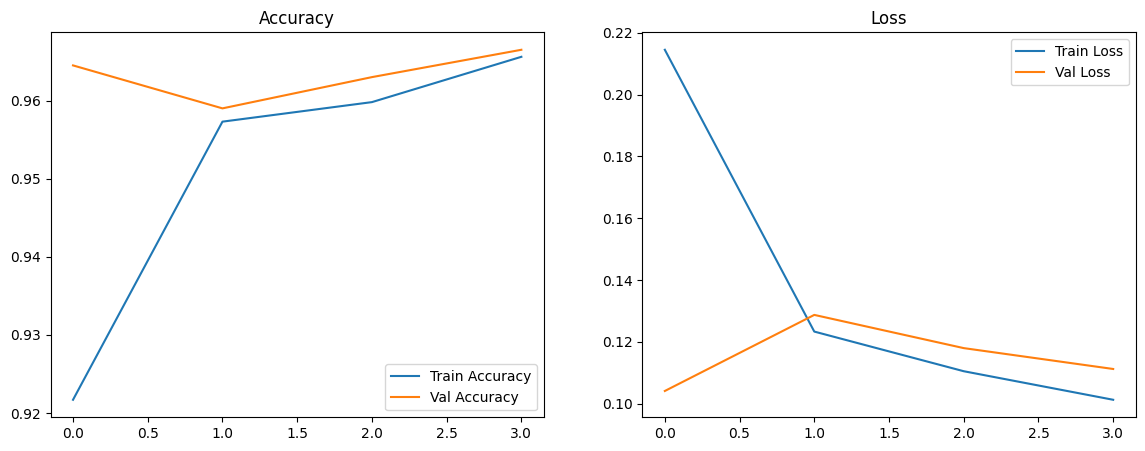

In [11]:
# ploting akurasi dan loss pada data train dan val
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(train_acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

# EVALUASI MODEL

In [12]:
# Evaluasi model
train_loss, train_accuracy = model.evaluate(train_ds)
print(f'Train loss: {train_loss}')
print(f'Train accuracy: {train_accuracy}')

val_loss, val_accuracy = model.evaluate(val_ds)
print(f'valid loss: {val_loss}')
print(f'valid accuracy: {val_accuracy}')

test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step - accuracy: 0.9608 - loss: 0.1177
Train loss: 0.1145818829536438
Train accuracy: 0.9599999785423279
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.9556 - loss: 0.1330
valid loss: 0.10408350825309753
valid accuracy: 0.9645000100135803
63/63 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9446 - loss: 0.1446
Test loss: 0.12034674733877182
Test accuracy: 0.9520000219345093


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

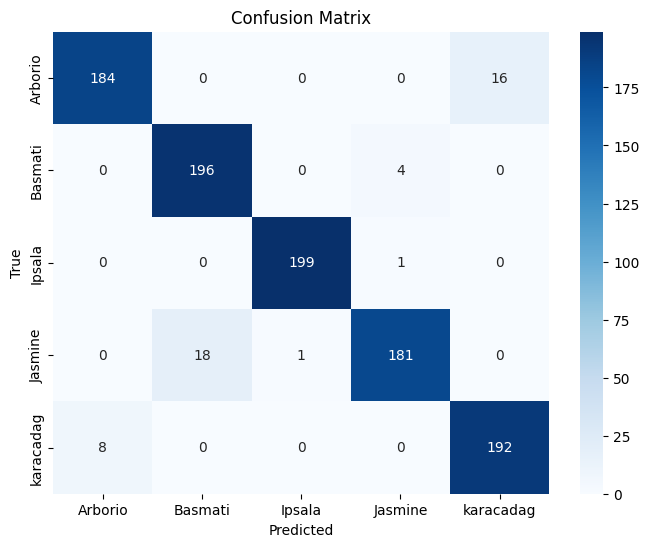

Classification Report:

              precision    recall  f1-score   support

     Arborio       0.96      0.92      0.94       200
     Basmati       0.92      0.98      0.95       200
      Ipsala       0.99      0.99      0.99       200
     Jasmine       0.97      0.91      0.94       200
   karacadag       0.92      0.96      0.94       200

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



In [13]:
# evaluasi dengan classification report dan confusion matrix
# Gabungkan semua batch dari test_ds jadi satu array
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# MENYIMPAN MODEL

## SAVE MODEL

In [14]:
# Simpan model dalam format SavedModel
model.export("/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/saved_model/cnn_model")

Saved artifact at '/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/saved_model/cnn_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132210560624080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132212534677520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132212534684048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132212534687888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132212534689232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132210400936976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132210400936208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132210400937936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132210400937744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132210400938704: 

## TFLite

In [15]:
# Konversi ke format TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/saved_model/cnn_model")
# gunakan MLIR-based converter yang baru
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Simpan model TFLite
with open("/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

## TFJS

In [36]:
# simpan model dalam hdf5
model.save("model.h5")

In [32]:
# load model .h5
model = load_model("model.h5")

In [15]:
# konversi ke tfjs
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-04-12 13:14:55.369268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744463695.427241    3148 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744463695.453544    3148 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [17]:
# memindahkan ke direktori yang benar
!mv "/content/tfjs_model" "/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/"

# INFERENCE MODEL

In [48]:
# INFERENCE MODEL MENGGUNAKAN DATASET YANG TIDAK DIGUNAKAN DALAM TRAIN, VAL, TEST DENGAN MEMBANDINGKAN DATASET SEBELUM DIPERKECIL DENGAN YG DIGUNAKAN UNTUK PEMODELAN (DATASET_KECIL), SAYA AMBIL PADA DATA TRAIN
# Path asli dan path dataset kecil
original_path = "/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_split/train"
used_path = "/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_kecil/train"
output_path = "/content/1_gambar_uji"

os.makedirs(output_path, exist_ok=True)

# Pilih kelas
class_name = random.choice(os.listdir(original_path))
print("Random class dipilih:", class_name)

# Ambil list gambar asli dan yang sudah dipakai
original_images = set(os.listdir(os.path.join(original_path, class_name)))
used_images = set(os.listdir(os.path.join(used_path, class_name)))

# Cari yang belum dipakai
remaining_images = list(original_images - used_images)

# Ambil satu secara acak
random_image = random.choice(remaining_images)
print("Gambar diambil:", random_image)

# Copy ke folder output
shutil.copy(
    os.path.join(original_path, class_name, random_image),
    os.path.join(output_path, f"{class_name}_{random_image}")
)

Random class dipilih: Jasmine
Gambar diambil: Jasmine (2062).jpg


'/content/1_gambar_uji/Jasmine_Jasmine (2062).jpg'

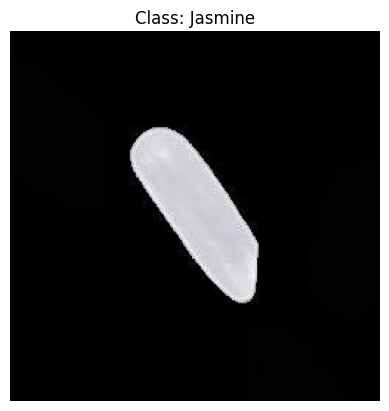

In [49]:
# MENAMPILKAN GAMBAR YANG DIGUNAAKN UNTUK INFERENCE MODEL
# Path lengkap gambar yang disalin
selected_image_path = os.path.join(output_path, f"{class_name}_{random_image}")

# Tampilkan gambar
img = mpimg.imread(selected_image_path)
plt.imshow(img)
plt.title(f"Class: {class_name}")
plt.axis('off')
plt.show()

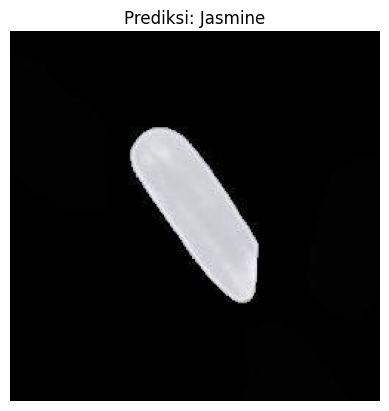

In [50]:
# PREDIKSI GAMBAR DENGAN TFLITE

# Path model TFLite
tflite_model_path = "/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/tflite/model.tflite"

# Path ke gambar yang baru disalin
test_image_path = os.path.join(output_path, f"{class_name}_{random_image}")

# Direktori dataset untuk mengambil nama folder kelas secara otomatis
dataset_path = '/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/dataset_kecil/train'

# Ambil nama folder (kelas) dan urutkan
class_names = sorted(os.listdir(dataset_path))

# Load dan preprocess gambar
img = cv2.imread(test_image_path)
img = cv2.resize(img, (128, 128))
img = img.astype(np.float32) / 255.0
img = np.expand_dims(img, axis=0)

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Ambil info input/output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Set input
interpreter.set_tensor(input_details[0]['index'], img)

# Jalankan inference
interpreter.invoke()

# Ambil hasil output
output = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output)

# Dapatkan label kelas yang diprediksi
predicted_label = class_names[predicted_class]

# Tampilkan gambar dan prediksi
plt.imshow(cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB))
plt.title(f"Prediksi: {predicted_label}")
plt.axis('off')
plt.show()

In [52]:
# membuat file requirements.txt
!pip freeze > requirements.txt

In [54]:
!mv "/content/requirements.txt" "/content/drive/MyDrive/ML dicoding/pengembangan ml/submission/"